# Exposure time factor 
Lets re-fit polynomial regression fits for the exposure time factor using a combination of BOSS sky flux data and DESI CMX sky flux data. Exposure time factor from sky brightness is calculated as

$t_{\rm BGS} = t_{\rm nom} \frac{(\rm sky~flux) t_{\rm nom} + \sqrt{t_{\rm nom}^2 (\rm sky~flux)_{\rm BGS}^2 + 4{\rm RN}^2 ((\rm sky~flux)_{\rm nom}t_{\rm nom} + {\rm RN}^2)}}{2((\rm sky~flux)_{\rm nom} t_{\rm nom} + {\rm RN}^2)}$ at $5000\AA$


**updates**: 
- April 8, 2020: LinearRegression adjusted to Ridge so that the coefficients are regularized. Exposure factor model fit to sky fluxes at 7000A because exposure factor based on 4500A ended up being too conservative (i.e. too large)
- **May 26, 2020**: Previous throughput correction on sky brightness was incorrect because it corrected for PSF fiber loss. Previous sky brightnesses overestimated $f_{\rm sky}$ by ~4x. Exposure factor model re-fit to sky updated sky brightness at 7000A. 
- **June 11, 2020**: previous $f_{\rm sky}$ did not account for read noise, which has a significant impact. Also, as Sclegel commented, 5000A is a better wavelength to measure $f_{\rm sky}$ -- but it doesn't make a significant impact. $f_{\rm sky}$ above also depends slightly on $t_{\rm nom}$. To be conservatve we'll use 200s. 
- **June 12, 2020**: Choice of $t_{\rm nom}$ depends strongly on the choice of minimum $\Delta \chi^2$ in `redrock`. To play it safe, lets allow $t_{\rm nom}$ to vary

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from scipy.signal import medfilt
from scipy.interpolate import interp1d
# --- desihub ---
import desisim.simexp
import specsim.instrument
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
if 'NERSC_HOST' not in os.environ:
    dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'
    dir_sky = '/Users/ChangHoon/data/feasiBGS/sky/'
else: 
    dir_cmx = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'
    dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

In [4]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

instrument = specsim.instrument.initialize(config, True)

plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

desi_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)
print('mean desi fiber area %f' % desi_fiber_area.value)

boss_fiber_area = np.pi

nom_waves = [] 
for camera in instrument.cameras: 
    nom_waves.append(camera.output_wavelength.value)

mean desi fiber area 1.862089


In [5]:
def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    #fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.cmx.v1.hdf5'), 'r')
    
    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
        
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['date', 'tileid', 'expid', 
              'airmass', 'moon_ill', 'moon_alt', 'moon_sep', 
              'sun_alt', 'sun_sep', 'exptime']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['date'][_i] = sky_data['date'][_i_uniq]
        sky_uniq_exps['tileid'][_i] = sky_data['tileid'][_i_uniq]
        sky_uniq_exps['expid'][_i] = sky_data['expid'][_i_uniq]
        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]

        sky_uniq_exps['sun_alt'][_i] = np.median(sky_data['sun_alt'][_is_exp])
        sky_uniq_exps['sun_sep'][_i] = np.median(sky_data['sun_sep'][_is_exp])        
        #sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0)

        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_sb_b'][_is_exp], axis=0) 
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_sb_r'][_is_exp], axis=0) 
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_sb_z'][_is_exp], axis=0)

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

In [6]:
def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [7]:
cmx_skies = read_cmx_skies()

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.692321
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.557860
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.423687
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.292890
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.162246
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.026271
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.209427
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.061903
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.944160
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.827312
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.710167
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.593746
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.477009
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [8]:
boss_skies = read_BOSS_skies()

remove boss skies during twilight defined as: sun_alt > -15

In [9]:
twilight = boss_skies['sun_alt'] > -15.
print('%i of %i are twilight' % (np.sum(twilight), len(boss_skies['sun_alt'])))

40 of 1144 are twilight


In [10]:
for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][~twilight]

## observing conditions of CMX and BOSS sky data

[]

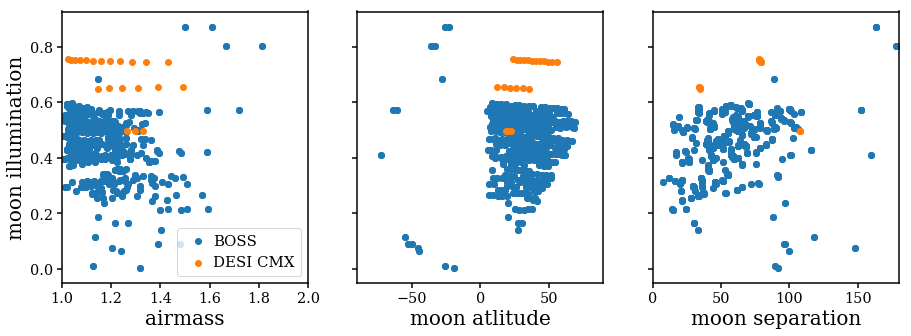

In [11]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C1', label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C1', label='DESI CMX')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

lets read in the nominal dark time sky surface brightness

In [12]:
# nominal dark sky
atm_config  = config.atmosphere
sb_dict     = config.load_table(atm_config.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark']

# also calculate nominal sky electrons for 150s exposure and read noise electrons
nom_sky_fibflux = Isky_dark * desi_fiber_area 

In [13]:
Isky_cont_dark = medfilt(Isky_dark, 1001)

Lets compare the model and data from randomly chosen exposures

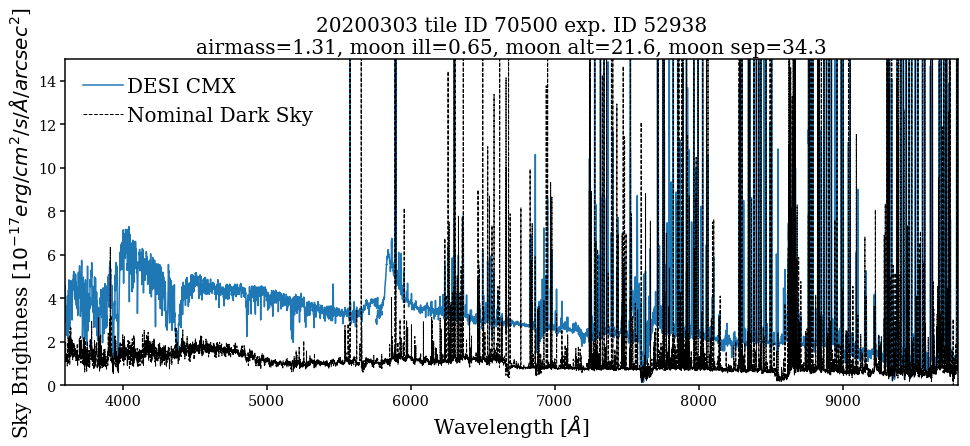

In [14]:
fig = plt.figure(figsize=(16, 6))
sub = fig.add_subplot(111)

iexp = np.random.choice(np.arange(len(cmx_skies['airmass'])))
sub.plot(cmx_skies['wave_b'], cmx_skies['sky_b'][iexp], c='C0')
sub.plot(cmx_skies['wave_r'], cmx_skies['sky_r'][iexp], c='C0')
sub.plot(cmx_skies['wave_z'], cmx_skies['sky_z'][iexp], c='C0', label='DESI CMX')
sub.plot(wave.value, Isky_dark, c='k', ls='--', lw=1, label='Nominal Dark Sky')
sub.set_title('%i tile ID %i exp. ID %i\nairmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
              (cmx_skies['date'][iexp], cmx_skies['tileid'][iexp], cmx_skies['expid'][iexp], 
               cmx_skies['airmass'][iexp], cmx_skies['moon_ill'][iexp], 
               cmx_skies['moon_alt'][iexp], cmx_skies['moon_sep'][iexp]), fontsize=20)
sub.set_xlabel("Wavelength [$\AA$]", fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('Sky Brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
sub.set_ylim(0., 15.)
sub.legend(loc='upper left', fontsize=20, handletextpad=0.2)

Text(0.5,0,'Wavelength [$\\AA$]')

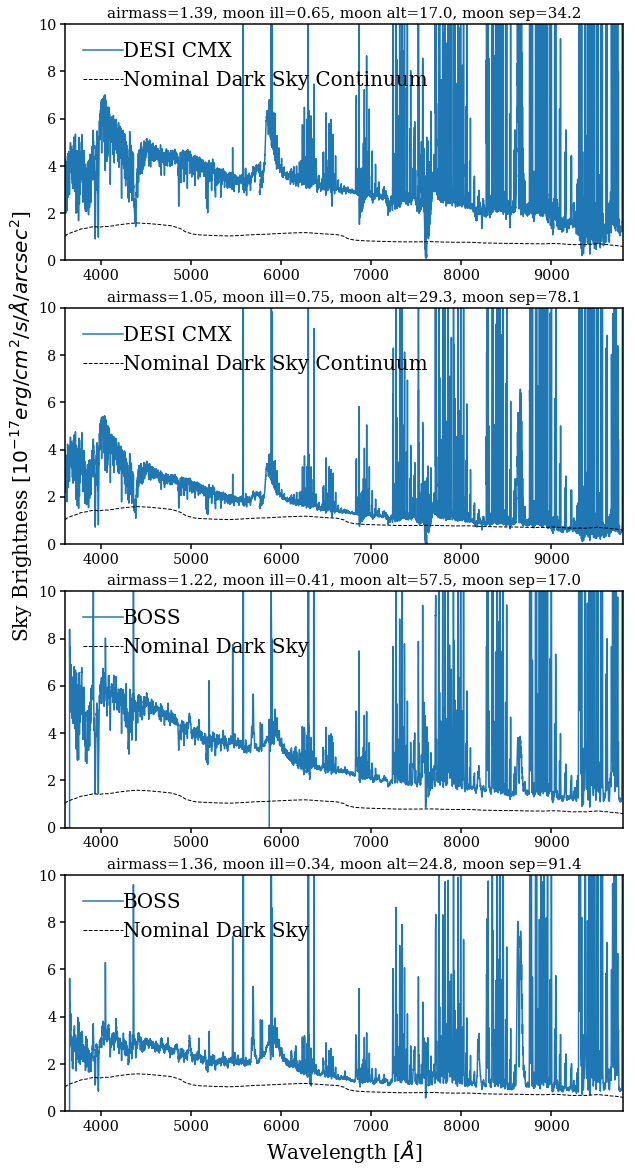

In [15]:
fig = plt.figure(figsize=(10, 20))
for i, iexp in enumerate(np.random.choice(np.arange(len(cmx_skies['airmass'])), size=2, replace=False)):
    sub = fig.add_subplot(4,1,i+1)
    sub.plot(cmx_skies['wave_b'], cmx_skies['sky_b'][iexp], c='C0')
    sub.plot(cmx_skies['wave_r'], cmx_skies['sky_r'][iexp], c='C0')
    sub.plot(cmx_skies['wave_z'], cmx_skies['sky_z'][iexp], c='C0', label='DESI CMX')
    sub.plot(wave.value, Isky_cont_dark, c='k', ls='--', lw=1, label='Nominal Dark Sky Continuum')
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
                  (cmx_skies['airmass'][iexp], cmx_skies['moon_ill'][iexp], 
                   cmx_skies['moon_alt'][iexp], cmx_skies['moon_sep'][iexp]), fontsize=15)
    sub.set_xlim(3600, 9800)
    sub.set_ylim(0., 10.)
    sub.legend(loc='upper left', fontsize=20, handletextpad=0)
sub.set_ylabel('Sky Brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    
for i, iexp in enumerate(np.random.choice(np.arange(len(boss_skies['airmass'])), size=2, replace=False)):
    sub = fig.add_subplot(4,1,i+3)
    sub.plot(boss_skies['wave_b'][iexp], boss_skies['sky_b'][iexp], c='C0', label='BOSS')
    sub.plot(boss_skies['wave_r'][iexp], boss_skies['sky_r'][iexp], c='C0')
    sub.plot(wave.value, Isky_cont_dark, c='k', ls='--', lw=1, label='Nominal Dark Sky')
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon alt=%.1f, moon sep=%.1f' % 
                  (boss_skies['airmass'][iexp], boss_skies['moon_ill'][iexp], 
                   boss_skies['moon_alt'][iexp], boss_skies['moon_sep'][iexp]), fontsize=15)
    sub.legend(loc='upper left', fontsize=20, handletextpad=0)
    sub.set_xlim(3600, 9800)
    sub.set_ylim(0., 10.)
sub.set_xlabel("Wavelength [$\AA$]", fontsize=20)

In [16]:
def get_exposure_factor(_wave_sb, _sky_sb, tnom=150, wavelength=5000):
    if wavelength < nom_waves[0].max(): 
        i_cam = 0 
    elif nom_waves[0].max() < wavelength & wavelength < nom_waves[1].max(): 
        i_cam = 1
    elif nom_waves[1].max() < wavelength:
        i_cam = 2
    else: 
        raise ValueError
        
    # first calculate nominal sky electrons and the read noise term (read noise electrons^2)
    nom_sky_photon = nom_sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * tnom * u.s
    camera = instrument.cameras[i_cam]

    nom_sky_electron = camera.downsample(camera.apply_resolution(nom_sky_photon * camera.throughput))    
    read_noise_electron = camera.downsample(camera.read_noise_per_bin.to(u.electron).value)
    rn_term = read_noise_electron**2
        
    # stitch together the spectrographs
    sbs_interp = [] 
    for _w, _sb in zip(_wave_sb, _sky_sb): 
        fintrp = interp1d(_w, _sb, fill_value=0., bounds_error=False) 
        sbs_interp.append(fintrp(wave))
    
    _sbs = np.amax(sbs_interp, axis=0)         

    sky_sb = _sbs * Isky_dark.unit
    sky_fibflux = sky_sb * desi_fiber_area 
    sky_photon = sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * tnom * u.s

    camera = instrument.cameras[i_cam]
    sky_electron = camera.downsample(camera.apply_resolution(sky_photon * camera.throughput))

    sky_bgs = np.interp(wavelength, camera.output_wavelength.value, sky_electron)
    rn = np.interp(wavelength, nom_waves[i_cam], rn_term)
    sky_nom = np.interp(wavelength, nom_waves[i_cam], nom_sky_electron)

    fsky = (sky_bgs + np.sqrt(sky_bgs**2 + 4 * rn * (sky_nom + rn)))/(2. * (sky_nom + rn))
    return fsky

Lets see how the exposure factors change with observing conditions

In [17]:
desi_tnom200_4000 = np.zeros(len(cmx_skies['airmass']))
desi_tnom200_5000 = np.zeros(len(cmx_skies['airmass']))
desi_tnom200_7000 = np.zeros(len(cmx_skies['airmass']))

_waves = [cmx_skies['wave_b'], cmx_skies['wave_r'], cmx_skies['wave_z']]
for i in range(len(cmx_skies['airmass'])): 
    _sky_sbs_i = [cmx_skies['sky_b'][i], cmx_skies['sky_r'][i], cmx_skies['sky_z'][i]]

    desi_tnom200_4000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=4000)
    desi_tnom200_5000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=5000)
    desi_tnom200_7000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=7000)

In [18]:
boss_tnom200_4000 = np.zeros(len(boss_skies['airmass']))
boss_tnom200_5000 = np.zeros(len(boss_skies['airmass']))
boss_tnom200_7000 = np.zeros(len(boss_skies['airmass']))

_waves = [boss_skies['wave_b'][i], boss_skies['wave_r'][i]]
for i in range(len(boss_skies['airmass'])): 
    _sky_sbs_i = [boss_skies['sky_b'][i], boss_skies['sky_r'][i]]

    boss_tnom200_4000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=4000)
    boss_tnom200_5000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=5000)
    boss_tnom200_7000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=7000)    

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


(0.0, 4.0)

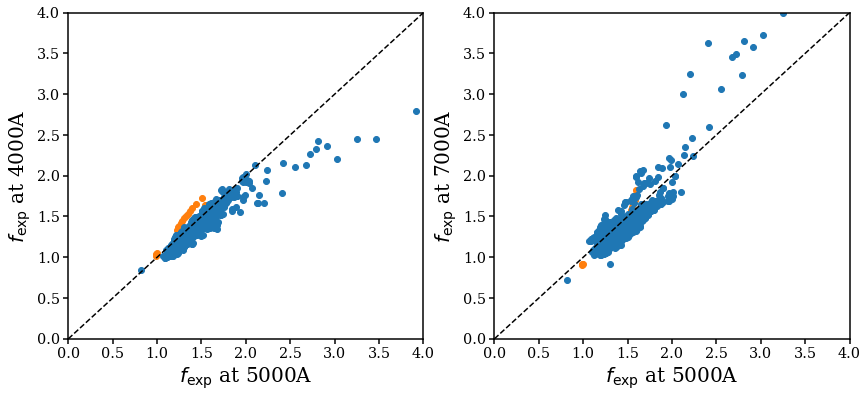

In [23]:
fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)
sub.scatter(desi_tnom200_5000, desi_tnom200_4000, c='C1')
sub.scatter(boss_tnom200_5000, boss_tnom200_4000, c='C0')
sub.plot([0., 4.], [0., 4.], c='k', ls='--')
sub.set_xlabel(r'$f_{\rm exp}$ at 5000A', fontsize=20)
sub.set_xlim(0., 4.)
sub.set_ylabel(r'$f_{\rm exp}$ at 4000A', fontsize=20)
sub.set_ylim(0., 4.)

sub = fig.add_subplot(122)
sub.scatter(desi_tnom200_5000, desi_tnom200_7000, c='C1')
sub.scatter(boss_tnom200_5000, boss_tnom200_7000, c='C0')
sub.plot([0., 4.], [0., 4.], c='k', ls='--')
sub.set_xlabel(r'$f_{\rm exp}$ at 5000A', fontsize=20)
sub.set_xlim(0., 4.)
sub.set_ylabel(r'$f_{\rm exp}$ at 7000A', fontsize=20)
sub.set_ylim(0., 4.)

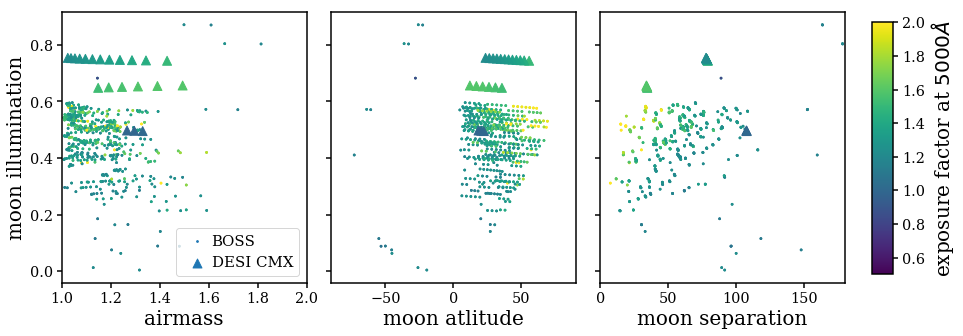

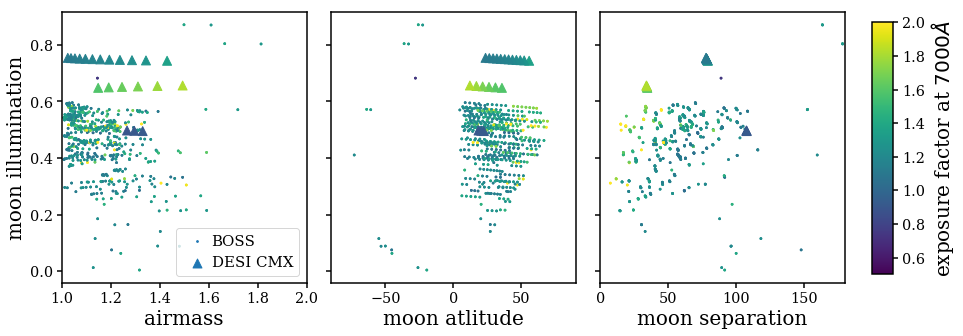

In [19]:
boss_5000 = boss_tnom200_5000
desi_5000 = desi_tnom200_5000

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_5000, s=3, vmin=0.5, vmax=2., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_5000, s=80, vmin=0.5, vmax=2., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_5000, s=3, vmin=0.5, vmax=2)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', c=desi_5000, s=80, vmin=0.5, vmax=2.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_5000, s=3, vmin=0.5, vmax=2.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_5000, s=80, vmin=0.5, vmax=2.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='exposure factor at $5000\AA$', fontsize=20)

boss_7000 = boss_tnom200_7000
desi_7000 = desi_tnom200_7000

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_7000, s=3, vmin=0.5, vmax=2., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_7000, s=80, vmin=0.5, vmax=2., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_7000, s=3, vmin=0.5, vmax=2)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', c=desi_7000, s=80, vmin=0.5, vmax=2.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_7000, s=3, vmin=0.5, vmax=2.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_7000, s=80, vmin=0.5, vmax=2.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='exposure factor at $7000\AA$', fontsize=20)

Lets compare these exposure factors to what is predicted by the current exposure time factor in `desisurvey` and `surveysim`

In [20]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from itertools import chain, combinations_with_replacement

In [21]:
# version after https://github.com/changhoonhahn/desisurvey/blob/a2a0470865fbfd8027007b46094780916cb1ba65/py/desisurvey/etc.py
# versoin before 06/12/2020

_notwiCoefficients_7000 = np.array([ 
    0.00000000e+00, -3.06734265e-01,  1.57082304e+00, -3.35343351e-01,
       -2.03056122e-01, -7.30090335e-01,  5.72356040e-01,  3.01764843e-03,
       -5.45585474e-02,  1.48250330e+00, -2.52524937e-01,  1.75945242e-01,
        4.98689969e-03,  5.24705825e-03,  5.81301210e-04,  2.45347173e-01,
       -1.28806111e+00, -6.11335448e-03, -1.96513906e-02,  2.11033948e+00,
        1.31154300e-01, -2.10494979e-02, -4.11198623e-04,  1.21362488e-03,
        1.70503232e-03,  2.33853699e-01, -8.33345021e-02,  9.89043893e-02,
        1.11211320e-03, -1.83236978e-03, -1.40550846e-03, -1.91730371e-05,
       -3.87822412e-05, -3.00280080e-05, -2.81428993e-06])


def exposure_factor_model_v0(airmass, moon_frac, moon_sep, moon_alt, wavelength=4500):
    ''' exposure factor model version 0 implemented in desisurvey and surveysim
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, 4))
    theta_transform = np.empty((theta.shape[0], 35))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)
        
    if wavelength == 7000: 
        _notwi_coeff = _notwiCoefficients_7000
        offset = 12.127093815588204
    return np.dot(theta_transform, _notwi_coeff.T) + offset

In [22]:
model_v0_7000 = exposure_factor_model_v0(
    np.concatenate([cmx_skies['airmass'], boss_skies['airmass']]),
    np.concatenate([cmx_skies['moon_ill'], boss_skies['moon_ill']]),
    np.concatenate([cmx_skies['moon_sep'], boss_skies['moon_sep']]),
    np.concatenate([cmx_skies['moon_alt'], boss_skies['moon_alt']]), 
    wavelength=7000)

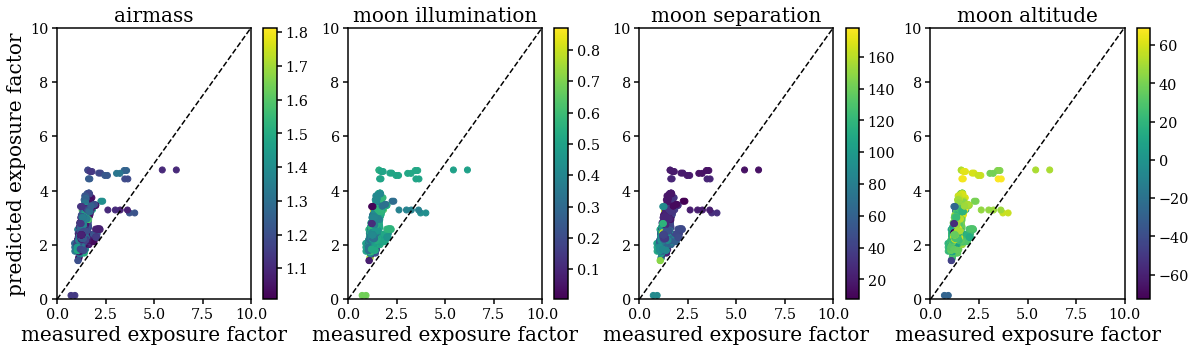

In [23]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']
    
fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(np.concatenate([desi_7000, boss_7000]), model_v0_7000, c=np.concatenate([cmx_skies[k], boss_skies[k]]))
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlabel('measured exposure factor', fontsize=20)
    sub.set_xlim([0., 10.])
    if i == 0: sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

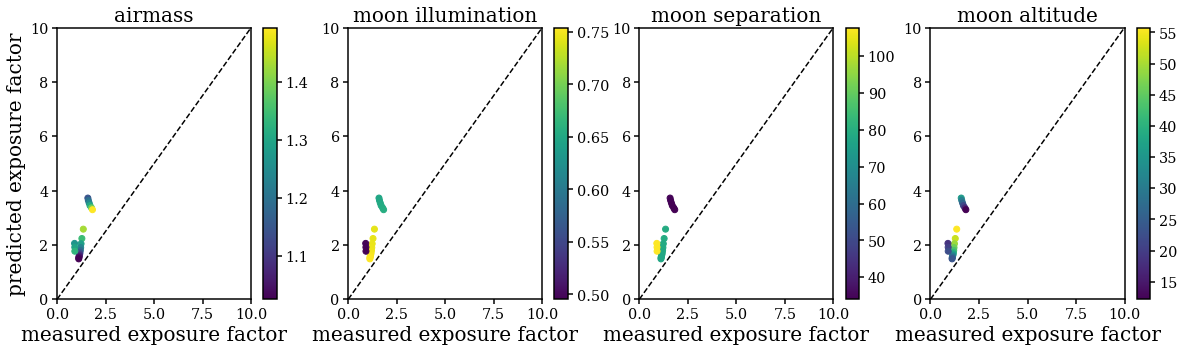

In [24]:
desi_model_v0_7000 = exposure_factor_model_v0(
    cmx_skies['airmass'], 
    cmx_skies['moon_ill'], 
    cmx_skies['moon_sep'], 
    cmx_skies['moon_alt'], 
    wavelength=7000)

fig = plt.figure(figsize=(20,5))
for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
    sub = fig.add_subplot(1,4,i+1)
    _plt = sub.scatter(desi_7000, desi_model_v0_7000, c=cmx_skies[k])
    sub.plot([0., 20.], [0., 20.], c='k', ls='--')
    sub.set_xlabel('measured exposure factor', fontsize=20)
    sub.set_xlim([0., 10.])
    if i == 0: sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([0., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

The previous CMX sky brightnesses included an incorrect correction for fiber loss. It therefore overestimated the sky brightness (above). Lets fit exposure factors using the DESI CMX and BOSS sky data

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 150 --
[ 0.00000000e+00 -2.49708184e-02  2.52486199e-01 -5.46363860e-02
 -3.46385860e-02 -8.36386831e-02  1.30105577e-01  9.66533278e-03
 -1.57508886e-02  3.28351095e-01 -1.42550850e-02  6.94343483e-02
  6.09900406e-04  7.10071258e-04  6.99453704e-06  5.68048827e-02
 -8.17988318e-02 -1.02939149e-02  1.95714560e-03  4.73877963e-01
  6.16920067e-03 -1.95719175e-02  1.12020673e-04  2.91442987e-04
  3.32396877e-04 -8.34800862e-02 -1.98454417e-02  6.46925683e-03
  1.37811319e-04 -3.58565949e-04 -1.98283765e-04 -3.10800386e-06
 -6.15677754e-06 -5.05207439e-06 -3.90575869e-07]
2.5862319238450633


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 170 --
[ 0.00000000e+00 -2.80592741e-02  2.82519650e-01 -6.12337075e-02
 -3.88977732e-02 -9.38911644e-02  1.45640129e-01  1.08522543e-02
 -1.77011318e-02  3.69075912e-01 -1.59220598e-02  7.78362001e-02
  6.82898179e-04  7.97210414e-04  9.66859468e-06  6.36858560e-02
 -9.14042425e-02 -1.15491329e-02  2.24059564e-03  5.32649118e-01
  6.89977186e-03 -2.19650156e-02  1.25688485e-04  3.26261642e-04
  3.72266191e-04 -9.30181217e-02 -2.22376944e-02  7.12176891e-03
  1.53774966e-04 -4.01348718e-04 -2.20093665e-04 -3.47892160e-06
 -6.90089062e-06 -5.68062255e-06 -4.52580016e-07]
2.777513688414931


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 200 --
[ 0.00000000e+00 -3.25370591e-02  3.24502646e-01 -7.06229367e-02
 -4.48817655e-02 -1.08639662e-01  1.67330251e-01  1.26047574e-02
 -2.06369392e-02  4.27089974e-01 -1.82413474e-02  8.98795572e-02
  7.85960945e-04  9.21368404e-04  1.34633923e-05  7.32368512e-02
 -1.04924141e-01 -1.33399319e-02  2.74422079e-03  6.16555294e-01
  7.95012256e-03 -2.54404656e-02  1.44795563e-04  3.74838366e-04
  4.28923997e-04 -1.07082915e-01 -2.56369357e-02  7.97087025e-03
  1.75981316e-04 -4.61519409e-04 -2.50772895e-04 -4.00060046e-06
 -7.95325622e-06 -6.57333165e-06 -5.42867923e-07]
3.0493419627360243


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 220 --
[ 0.00000000e+00 -3.54090517e-02  3.50535274e-01 -7.65461292e-02
 -4.86059816e-02 -1.18034491e-01  1.80761231e-01  1.37481237e-02
 -2.25858176e-02  4.63677195e-01 -1.96728246e-02  9.75288132e-02
  8.50491083e-04  9.99727418e-04  1.57829882e-05  7.91051191e-02
 -1.13375346e-01 -1.44713509e-02  3.12220581e-03  6.69585634e-01
  8.61955423e-03 -2.76741049e-02  1.56627998e-04  4.04884075e-04
  4.64616282e-04 -1.16288416e-01 -2.77776118e-02  8.45958480e-03
  1.89694119e-04 -4.99036366e-04 -2.69974746e-04 -4.32601284e-06
 -8.61296332e-06 -7.13458865e-06 -6.00526979e-07]
3.2206029229505133


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 250 --
[ 0.00000000e+00 -3.95359759e-02  3.86855546e-01 -8.49418723e-02
 -5.38149517e-02 -1.31459562e-01  1.99474452e-01  1.54171009e-02
 -2.54726885e-02  5.15464928e-01 -2.16613537e-02  1.08436519e-01
  9.41343709e-04  1.11078207e-03  1.88972724e-05  8.72069228e-02
 -1.25262911e-01 -1.60763023e-02  3.73514437e-03  7.44801918e-01
  9.57735146e-03 -3.08917481e-02  1.73102900e-04  4.46689897e-04
  5.15142065e-04 -1.29809522e-01 -3.08064535e-02  9.09387478e-03
  2.08767603e-04 -5.51634780e-04 -2.97076724e-04 -4.78259856e-06
 -9.54251416e-06 -7.92673637e-06 -6.82507628e-07]
3.4630959513567374


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 270 --
[ 0.00000000e+00 -4.21633435e-02  4.09380442e-01 -9.02263000e-02
 -5.70512472e-02 -1.39967512e-01  2.11065329e-01  1.64954804e-02
 -2.73615473e-02  5.47991633e-01 -2.28895878e-02  1.15338990e-01
  9.98176958e-04  1.18064967e-03  2.07237842e-05  9.21751932e-02
 -1.32693266e-01 -1.70868888e-02  4.16532521e-03  7.92137409e-01
  1.01853143e-02 -3.29461547e-02  1.83297027e-04  4.72546452e-04
  5.46905287e-04 -1.38612904e-01 -3.27094559e-02  9.46059035e-03
  2.20571012e-04 -5.84401967e-04 -3.14105220e-04 -5.06732555e-06
 -1.01243264e-05 -8.42295696e-06 -7.33962180e-07]
3.6155886844539435


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/astropy/units/quantity.py:643: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)


--- tnom = 300 --
[ 0.00000000e+00 -4.59178821e-02  4.40857124e-01 -9.77103513e-02
 -6.15791014e-02 -1.52082391e-01  2.27245400e-01  1.80577744e-02
 -3.01264231e-02  5.93932528e-01 -2.45997804e-02  1.25159593e-01
  1.07823168e-03  1.27952933e-03  2.31002043e-05  9.90392788e-02
 -1.43149683e-01 -1.85183472e-02  4.82986528e-03  8.59119827e-01
  1.10525881e-02 -3.58913747e-02  1.97510818e-04  5.08587660e-04
  5.91840950e-04 -1.51472896e-01 -3.53999993e-02  9.94136614e-03
  2.37046497e-04 -6.30379294e-04 -3.38234224e-04 -5.46729862e-06
 -1.09441607e-05 -9.12223323e-06 -8.06264099e-07]
3.8314019756655826


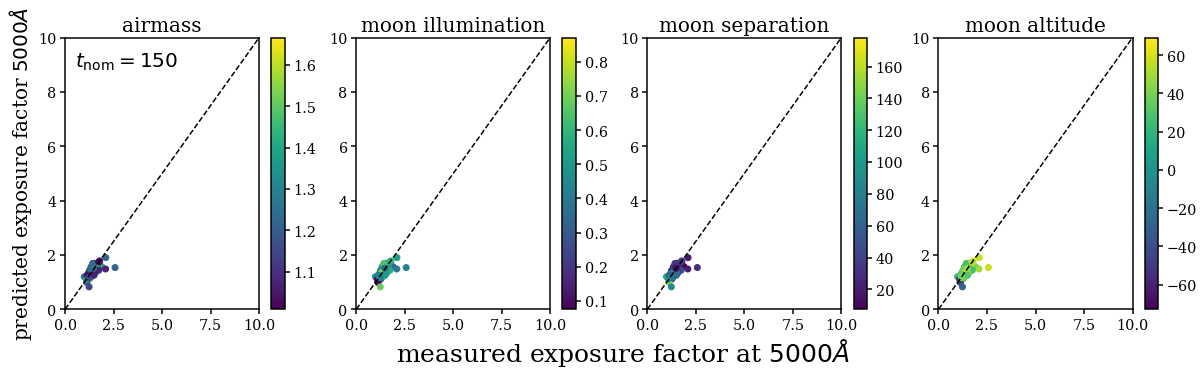

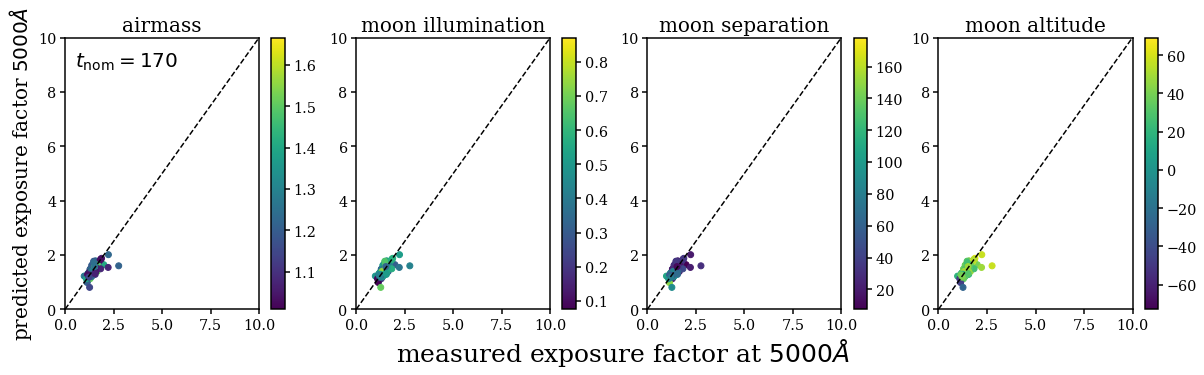

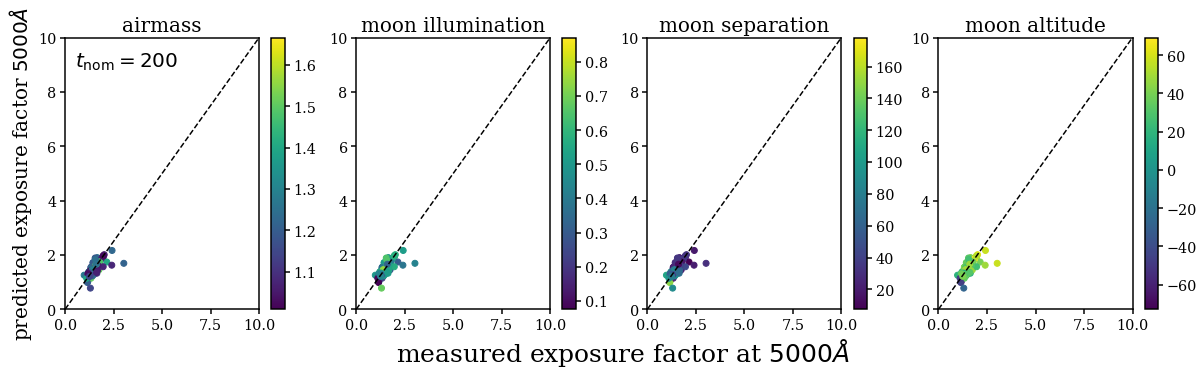

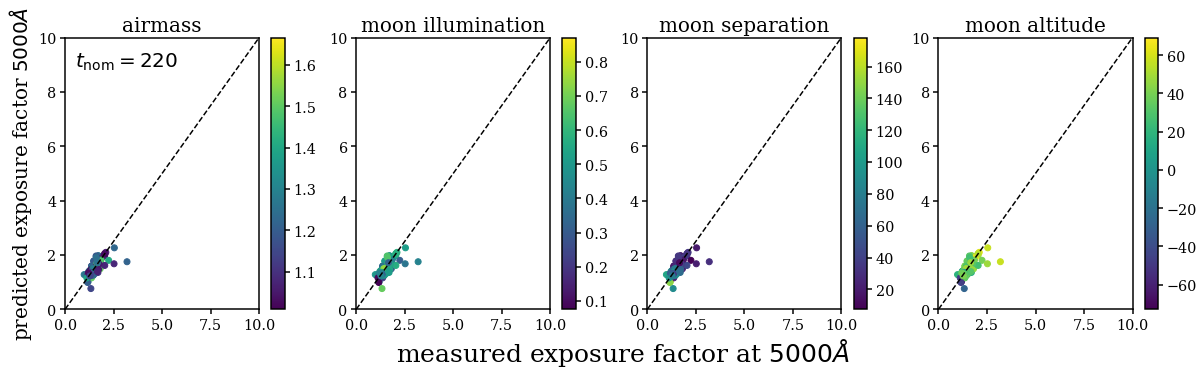

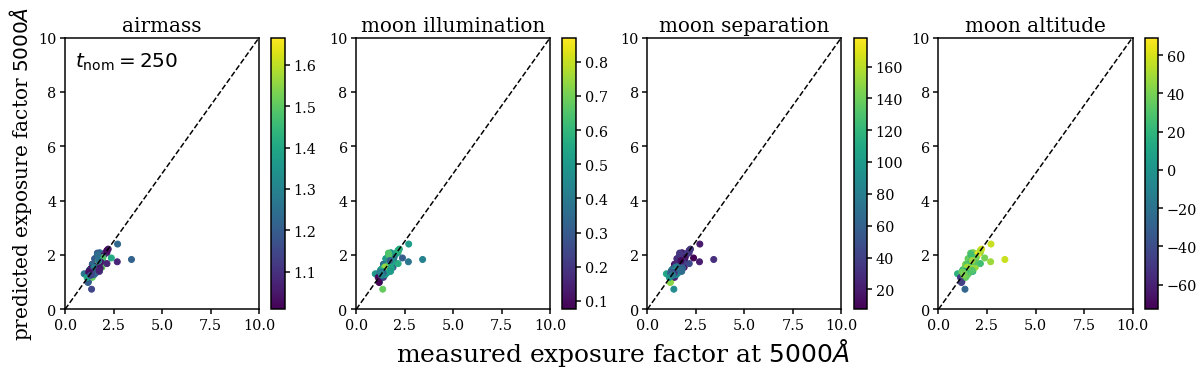

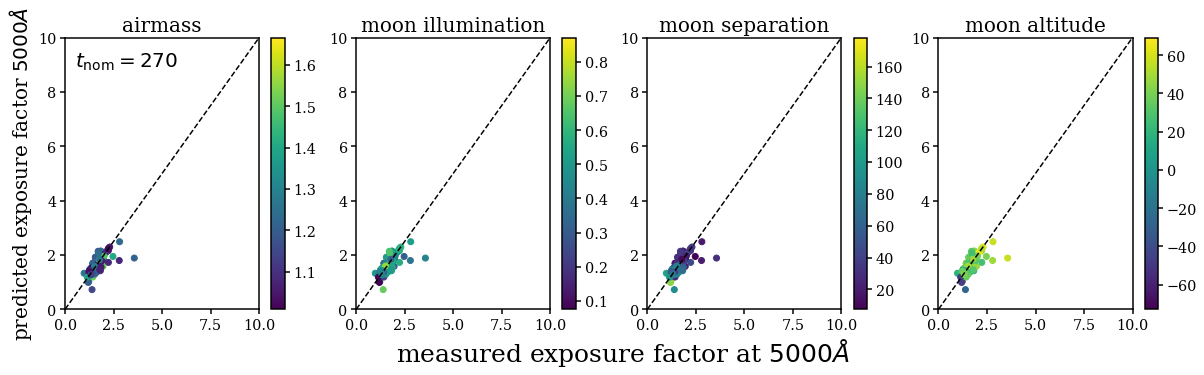

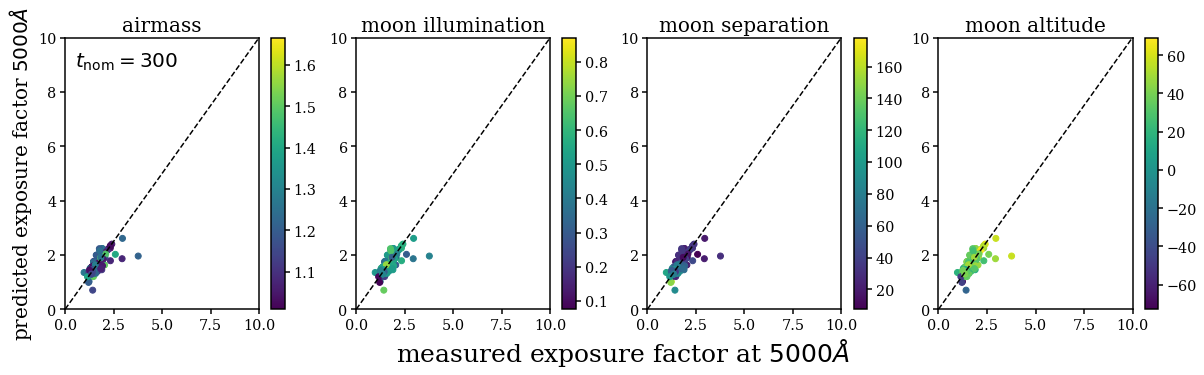

In [27]:
desi_waves = [cmx_skies['wave_b'], cmx_skies['wave_r'], cmx_skies['wave_z']]
boss_waves = [boss_skies['wave_b'][i], boss_skies['wave_r'][i]]

for tnom in [150, 170, 200, 220, 250, 270, 300]: 
    _desi_fsky = np.zeros(len(cmx_skies['airmass']))
    for i in range(len(cmx_skies['airmass'])): 
        _desi_fsky[i] = get_exposure_factor(desi_waves, [cmx_skies['sky_b'][i], cmx_skies['sky_r'][i], cmx_skies['sky_z'][i]], tnom=tnom, wavelength=5000)
        
    _boss_fsky = np.zeros(len(boss_skies['airmass']))
    for i in range(len(boss_skies['airmass'])): 
        _boss_fsky[i] = get_exposure_factor(boss_waves, [boss_skies['sky_b'][i], boss_skies['sky_r'][i]], tnom=tnom, wavelength=5000)

        
    theta_train, theta_test, fsky_train, fsky_test = train_test_split(
        np.vstack([
            np.concatenate([cmx_skies['airmass'], boss_skies['airmass']]),
            np.concatenate([cmx_skies['moon_ill'], boss_skies['moon_ill']]),
            np.concatenate([cmx_skies['moon_sep'], boss_skies['moon_sep']]),
            np.concatenate([cmx_skies['moon_alt'], boss_skies['moon_alt']])]).T, 
        np.concatenate([_desi_fsky, _boss_fsky]), test_size=0.2, random_state=0)
    
    n_order = 3
    regress_fsky = make_pipeline(PolynomialFeatures(n_order), Ridge(alpha=0.1))
    regress_fsky.fit(theta_train, fsky_train)
    
    steps = regress_fsky.get_params()
    _notwiCoefficients_v2 = steps['ridge'].coef_
    _notwiIntercept_v2 = steps['ridge'].intercept_
    
    print('--- tnom = %.f --' % tnom)
    print(_notwiCoefficients_v2)
    print(_notwiIntercept_v2)
    def exposure_factor_model_v2(airmass, moon_frac, moon_sep, moon_alt):
        ''' third degree polynomial regression fit to exposure factor
        '''
        _notwiCoefficients = _notwiCoefficients_v2
        _notwiIntercept = _notwiIntercept_v2

        theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

        combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, n_order+1))
        theta_transform = np.empty((theta.shape[0], len(_notwiCoefficients)))
        for i, comb in enumerate(combs):
            theta_transform[:, i] = theta[:, comb].prod(1)

        return np.dot(theta_transform, _notwiCoefficients.T) + _notwiIntercept
    
    fig = plt.figure(figsize=(20,5))
    for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
        sub = fig.add_subplot(1,4,i+1)
        _plt = sub.scatter(fsky_test, exposure_factor_model_v2(*theta_test.T), c=theta_test[:,i])
        sub.plot([0., 20.], [0., 20.], c='k', ls='--')
        sub.set_xlim([0., 10.])
        if i == 0: 
            sub.set_ylabel('predicted exposure factor $5000\AA$', fontsize=20)
            sub.text(0.05, 0.95, r'$t_{\rm nom} = %.f$' % tnom, transform=sub.transAxes, ha='left', va='top', fontsize=20)
        sub.set_ylim([0., 10.])
        sub.set_title(lbls[i], fontsize=20)
        fig.colorbar(_plt)

    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel('measured exposure factor at $5000\AA$', fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)